# Influenza A Wastewater 

Bu çalışmada, ABD CDC tarafından sağlanan atık su verileri kullanılarak  
**Influenza A varlığının (binary classification)** makine öğrenmesi yöntemleriyle tahmin edilmesi amaçlanmıştır.

Çalışma kapsamında:
- Veri temizliği ve özellik mühendisliği
- Farklı sınıflandırma modelleri
- Ensemble yöntemler
- Hyperparameter tuning
- Feature selection & dimension reduction
- Çeşitli performans metrikleri

kapsamlı biçimde değerlendirilmiştir.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import StratifiedKFold, GroupShuffleSplit, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform

from sklearn.ensemble import HistGradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import brier_score_loss


In [6]:
def pick_X(model_name, model, X_train_raw, X_test_raw, X_train_scaled, X_test_scaled):
    is_pipe = isinstance(model, Pipeline)
    is_tree_like = ("HistGradientBoosting" in model_name) or ("BaggingClassifier" in model_name)
    if is_pipe or is_tree_like:
        return X_train_raw, X_test_raw
    return X_train_scaled, X_test_scaled


## Veri Seti

- **Kaynak:** CDC – Wastewater Surveillance Data
- **Gözlem Birimi:** Atık su arıtma tesislerinde alınan örnekler
- **Hedef Değişken:**  
  `influenza_a_detected`  
  - 0: Influenza A tespit edilmedi  
  - 1: Influenza A tespit edildi

Veri seti; zaman, nüfus, akış hızı, PCR ölçümleri ve tesis bilgileri gibi
çok sayıda değişken içermektedir.


In [7]:
file_name = "CDC_Wastewater_Data_for_Influenza_A.csv"
df = pd.read_csv(file_name, low_memory=False)

df.head()


,sewershed_id,wwtp_jurisdiction,county_fips,counties_served,population_served,sample_id,sample_collect_date,sample_type,sample_matrix,sample_location,...,pcr_target_flowpop_lin,pcr_target_mic_lin,hum_frac_target_mic,hum_frac_mic_conc,hum_frac_mic_unit,rec_eff_percent,rec_eff_target_name,rec_eff_spike_matrix,rec_eff_spike_conc,date_updated
0,2407,al,01125,Tuscaloosa,12278,05a02bd4d68420ea7e9c030e8ce7fd08,2025-06-08,24-hr time-weighted composite,raw wastewater,wwtp,...,8.622591e+02,0.00000,pmmov (gt-digital),600053819.4,copies/l wastewater,24.2700,bcov vaccine,raw sample,5.000,09/26/2025 10:40:00 AM
1,2167,wi,55127,Walworth,30000,09e73eabdeca41f149d08ede0d92bbf1,2024-08-12,24-hr flow-weighted composite,raw wastewater,wwtp,...,1.259100e+07,0.00007,pepper mild mottle virus,358000000.0,copies/l wastewater,37.4095,bcov vaccine,raw sample,-1.000,09/26/2025 10:40:00 AM
2,488,il,17167,Sangamon,102000,0b751586bf4ed642b7d73402c69d58a1,2024-05-16,24-hr time-weighted composite,raw wastewater,wwtp,...,1.503026e+06,0.00002,pepper mild mottle virus,91321875.0,copies/l wastewater,41.3700,bcov vaccine,raw sample,5.884,09/26/2025 10:40:00 AM
3,434,il,17043,Du Page,59805,0e3eb697c96f9645c691e10631317c7c,2025-01-28,24-hr time-weighted composite,raw wastewater,wwtp,...,1.330717e+08,0.00048,pepper mild mottle virus,567984375.0,copies/l wastewater,48.7400,bcov vaccine,raw sample,5.884,09/26/2025 10:40:00 AM
4,97,ca,06013,Contra Costa,487300,176c33eaf7e144d6d9e2b5a9870b08bd,2025-02-05,24-hr flow-weighted composite,raw wastewater,wwtp,...,6.417332e+07,0.00017,pepper mild mottle virus,658805440.0,copies/l wastewater,79.4000,bcov vaccine,raw sample,4.963,09/26/2025 10:40:00 AM


## Veri Temizliği ve Özellik Mühendisliği

Bu bölümde aşağıdaki işlemler uygulanmıştır:

- Tarih değişkenlerinden zaman bazlı yeni feature’lar üretilmesi
- Eksik değerlerin mantıklı istatistiklerle doldurulması
- Logaritmik dönüşümler
- Rolling istatistikler
- Kategorik değişkenlerin sayısallaştırılması
- Olası veri sızıntısına (data leakage) yol açabilecek değişkenlerin çıkarılması

Amaç modeller için daha stabil ve anlamlı bir özellik uzayı oluşturmaktır.


In [8]:
df["sample_collect_date"] = pd.to_datetime(df["sample_collect_date"], errors="coerce")
df["collection_month"] = df["sample_collect_date"].dt.month
df["collection_week"] = df["sample_collect_date"].dt.isocalendar().week.astype(int)
df["collection_dayofweek"] = df["sample_collect_date"].dt.dayofweek

df["flow_rate_missing"] = df["flow_rate"].isnull().astype(int)
df["flow_rate"] = df["flow_rate"].fillna(df["flow_rate"].median())

df["flowpop_lin_missing"] = df["pcr_target_flowpop_lin"].isnull().astype(int)
df["pcr_target_flowpop_lin"] = df["pcr_target_flowpop_lin"].fillna(df["pcr_target_flowpop_lin"].median())

df["log_population_served"] = np.log1p(df["population_served"])
df["log_flow_rate"] = np.log1p(df["flow_rate"])

df["influenza_a_detected"] = (df["pcr_target_avg_conc"] > 0).astype(int)
df["log_pcr_target_conc"] = np.log1p(df["pcr_target_avg_conc"])

df = df.sort_values(by=["wwtp_jurisdiction", "sample_collect_date"])

df["log_conc_roll_avg_3"] = df.groupby("wwtp_jurisdiction")["log_pcr_target_conc"].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
df["log_conc_roll_std_3"] = df.groupby("wwtp_jurisdiction")["log_pcr_target_conc"].transform(
    lambda x: x.rolling(3, min_periods=1).std()
).fillna(0)

bins = [0, 20000, 50000, 200000, np.inf]
labels = ["Small", "Medium", "Large", "Very Large"]
df["population_group"] = pd.cut(df["population_served"], bins=bins, labels=labels, right=False)

count_map = df[df["influenza_a_detected"] == 1].groupby("wwtp_jurisdiction").size()
df["jurisdiction_positive_count"] = df["wwtp_jurisdiction"].map(count_map).fillna(0)

columns_to_drop = [
    "inhibition_adjust", "sample_id", "date_updated", "rec_eff_target_name",
    "rec_eff_spike_matrix", "rec_eff_spike_conc", "hum_frac_mic_unit",
    "pcr_target_mic_lin", "hum_frac_mic_conc", "hum_frac_target_mic",
    "ntc_amplify", "pcr_target"
]
df.drop(columns=columns_to_drop, inplace=True, errors="ignore")

df["pasteurized"] = df["pasteurized"].fillna(df["pasteurized"].mode()[0])
df["counties_served"] = df["counties_served"].fillna(df["counties_served"].mode()[0])
df["lod_sewage"] = df["lod_sewage"].fillna(df["lod_sewage"].median())
df["pcr_gene_target_agg"] = df["pcr_gene_target_agg"].fillna(df["pcr_gene_target_agg"].mode()[0])
df["rec_eff_percent"] = np.clip(df["rec_eff_percent"], a_min=None, a_max=100)

df.drop_duplicates(inplace=True)

pop_kategorileri = pd.CategoricalDtype(categories=["Small", "Medium", "Large", "Very Large"], ordered=True)
df["population_group"] = df["population_group"].astype(pop_kategorileri)
df["population_group_encoded"] = df["population_group"].cat.codes

df["log_pop_sq"] = df["log_population_served"] ** 2
df["log_flow_sq"] = df["log_flow_rate"] ** 2

df.shape


(212401, 39)

Boyut: 212401 satır, 39 sütun
0    123159
1     89242
Name: influenza_a_detected, dtype: int64


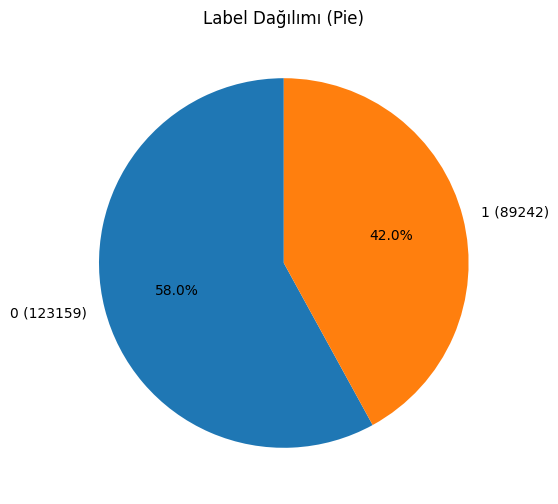

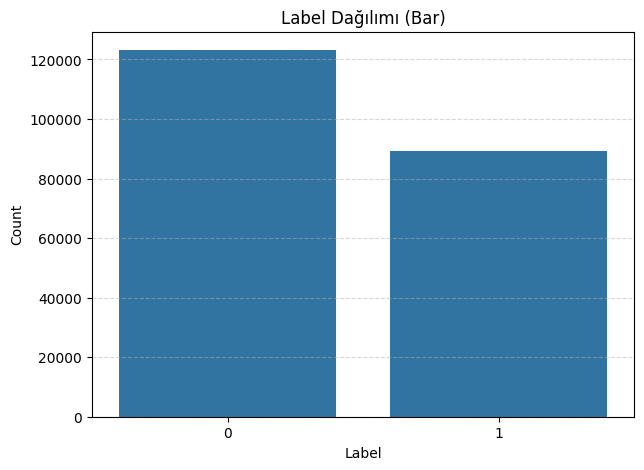

In [9]:
print(f"Boyut: {df.shape[0]} satır, {df.shape[1]} sütun")

label_counts = df["influenza_a_detected"].value_counts()
print(label_counts)

plt.figure(figsize=(6, 6))
plt.pie(
    label_counts.values,
    labels=[f"{lbl} ({cnt})" for lbl, cnt in label_counts.items()],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Label Dağılımı (Pie)")
plt.show()

plt.figure(figsize=(7, 5))
sns.barplot(x=label_counts.index.astype(str), y=label_counts.values)
plt.title("Label Dağılımı (Bar)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


## Train / Test Ayrımı ve Değerlendirme Stratejisi

- Veri, **GroupShuffleSplit** kullanılarak train ve test olarak ayrılmıştır.
- Aynı arıtma tesisine ait gözlemler hem train hem test setinde yer almayacak
  şekilde ayrım yapılmıştır.
- Bu yaklaşım, modelin **ezberlemesini önlemeyi** ve daha gerçekçi bir
  genelleme performansı ölçmeyi amaçlar.

Ek olarak:
- StratifiedKFold ile çapraz doğrulama yapılmıştır.


In [10]:
target_col = "influenza_a_detected"
X = df.drop(columns=[target_col], errors="ignore")
y = df[target_col].astype(int)

leak_cols = ["pcr_target_avg_conc", "log_pcr_target_conc", "log_conc_roll_avg_3", "log_conc_roll_std_3"]
X = X.drop(columns=leak_cols, errors="ignore")

groups = df["wwtp_jurisdiction"].astype(str)

X_numeric = X.select_dtypes(include=[np.number]).copy()
X_numeric = X_numeric.replace([np.inf, -np.inf], np.nan).fillna(0)

features_fs = X_numeric.columns.tolist()

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_numeric, y, groups=groups))

X_train = X_numeric.iloc[train_idx]
X_test  = X_numeric.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test  = y.iloc[test_idx]

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train dağılım:\n", y_train.value_counts())
print("Test dağılım:\n", y_test.value_counts())


Train: (176325, 18) Test: (36076, 18)
Train dağılım:
 0    102607
1     73718
Name: influenza_a_detected, dtype: int64
Test dağılım:
 0    20552
1    15524
Name: influenza_a_detected, dtype: int64


In [11]:
scaler = StandardScaler()
X_train_scaled_fs = scaler.fit_transform(X_train)
X_test_scaled_fs = scaler.transform(X_test)


## Kullanılan Modeller

Bu çalışmada aşağıdaki sınıflandırma modelleri kullanılmıştır:

- Logistic Regression
- K-Nearest Neighbors (KNN)
- HistGradientBoostingClassifier
- BaggingClassifier (Decision Tree tabanlı)

Ayrıca ensemble modeller için **hyperparameter tuning** uygulanmıştır.


In [12]:
base_models = {
    "LogisticRegression": LogisticRegression(max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "HistGradientBoosting": HistGradientBoostingClassifier(max_depth=6, max_iter=120, learning_rate=0.08, random_state=42),
    "BaggingClassifier": BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=6, random_state=42),
        n_estimators=40, max_samples=0.7, max_features=0.7,
        n_jobs=-1, random_state=42
    )
}

list(base_models.keys())


['LogisticRegression', 'KNN', 'HistGradientBoosting', 'BaggingClassifier']

## Hyperparameter Tuning

Ensemble modeller için:

- **RandomizedSearchCV**
- **StratifiedKFold**
- **ROC AUC** metriği

kullanılarak en iyi hiperparametre kombinasyonları aranmıştır.

Amaç:
- Model performansını artırmak
- Overfitting riskini azaltmak


In [13]:
tuning_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

tuning_spaces = {
    "HistGradientBoosting": {
        "model__max_iter": randint(60, 160),
        "model__learning_rate": uniform(0.03, 0.12),
        "model__max_depth": randint(3, 8),
        "model__min_samples_leaf": randint(10, 80)
    },
    "BaggingClassifier": {
        "model__n_estimators": randint(20, 80),
        "model__max_samples": uniform(0.5, 0.45),
        "model__max_features": uniform(0.5, 0.45),
        "model__estimator__max_depth": randint(3, 10),
        "model__estimator__min_samples_leaf": randint(5, 60)
    }
}

tuned_models = {}
tuned_best_params = {}
tuned_best_scores = {}

advanced_model_names = ["HistGradientBoosting", "BaggingClassifier"]

for adv_name in advanced_model_names:
    estimator = base_models[adv_name]
    pipe = Pipeline([("scaler", StandardScaler()), ("model", estimator)])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=tuning_spaces[adv_name],
        n_iter=12,
        scoring="roc_auc",
        cv=tuning_cv,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    search.fit(X_train, y_train)

    tuned_models[adv_name] = search.best_estimator_
    tuned_best_params[adv_name] = search.best_params_
    tuned_best_scores[adv_name] = search.best_score_

    print(adv_name, "best_auc:", round(search.best_score_, 4))
    print("best_params:", search.best_params_, "\n")

for adv_name, best_pipe in tuned_models.items():
    base_models[f"{adv_name}_Tuned"] = best_pipe

[k for k in base_models.keys() if "Tuned" in k]


Fitting 3 folds for each of 12 candidates, totalling 36 fits
HistGradientBoosting best_auc: 0.9815
best_params: {'model__learning_rate': 0.06650906915514453, 'model__max_depth': 7, 'model__max_iter': 148, 'model__min_samples_leaf': 58} 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BaggingClassifier best_auc: 0.9774
best_params: {'model__estimator__max_depth': 9, 'model__estimator__min_samples_leaf': 56, 'model__max_features': 0.9278214378844623, 'model__max_samples': 0.8293972738151323, 'model__n_estimators': 40} 



['HistGradientBoosting_Tuned', 'BaggingClassifier_Tuned']

In [14]:
base_model_results = {}

for model_name, model in base_models.items():
    Xtr_used, Xte_used = pick_X(model_name, model, X_train, X_test, X_train_scaled_fs, X_test_scaled_fs)

    model.fit(Xtr_used, y_train)
    y_pred = model.predict(Xte_used)
    y_pred_proba = model.predict_proba(Xte_used)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    roc_auc_val = auc(*roc_curve(y_test, y_pred_proba)[:2]) if y_pred_proba is not None else np.nan
    avg_precision = average_precision_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan
    ibs = brier_score_loss(y_test, y_pred_proba) if y_pred_proba is not None else np.nan

    base_model_results[model_name] = {
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba,
        "accuracy": acc,
        "roc_auc": roc_auc_val,
        "avg_precision": avg_precision,
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "ibs": ibs
    }

    print(model_name, "Acc:", round(acc, 4), "AUC:", round(roc_auc_val, 4), "IBS:", round(ibs, 4))


LogisticRegression Acc: 0.8976 AUC: 0.9653 IBS: 0.0788
KNN Acc: 0.7469 AUC: 0.7908 IBS: 0.1878
HistGradientBoosting Acc: 0.8646 AUC: 0.9665 IBS: 0.1251
BaggingClassifier Acc: 0.8534 AUC: 0.9327 IBS: 0.1096
HistGradientBoosting_Tuned Acc: 0.8636 AUC: 0.967 IBS: 0.1267
BaggingClassifier_Tuned Acc: 0.8638 AUC: 0.9445 IBS: 0.1146


In [15]:
skf_tt = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tt_summary = []
tt_oof_probs = {name: [] for name in base_models.keys()}
tt_oof_true = []

for fold, (tr_idx, te_idx) in enumerate(skf_tt.split(X_numeric, y), start=1):
    X_tr_raw, X_te_raw = X_numeric.iloc[tr_idx], X_numeric.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

    tt_oof_true.extend(y_te.tolist())

    for model_name, model in base_models.items():
        m = clone(model)

        is_pipe = isinstance(m, Pipeline)
        is_tree_like = ("HistGradientBoosting" in model_name) or ("BaggingClassifier" in model_name)

        if is_pipe or is_tree_like:
            Xtr_used, Xte_used = X_tr_raw, X_te_raw
        else:
            sc = StandardScaler()
            Xtr_used = sc.fit_transform(X_tr_raw)
            Xte_used = sc.transform(X_te_raw)

        m.fit(Xtr_used, y_tr)
        yhat = m.predict(Xte_used)

        prob = m.predict_proba(Xte_used)[:, 1] if hasattr(m, "predict_proba") else None
        if prob is not None:
            tt_oof_probs[model_name].extend(prob.tolist())

        tt_summary.append({
            "Fold": fold,
            "Model": model_name,
            "Accuracy": accuracy_score(y_te, yhat),
            "Precision": precision_score(y_te, yhat, zero_division=0),
            "Recall": recall_score(y_te, yhat, zero_division=0),
            "F1": f1_score(y_te, yhat, zero_division=0),
            "ROC_AUC": roc_auc_score(y_te, prob) if prob is not None else np.nan,
            "IBS": brier_score_loss(y_te, prob) if prob is not None else np.nan
        })

tt_df = pd.DataFrame(tt_summary)
tt_agg = tt_df.groupby("Model")[["Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "IBS"]].agg(["mean", "std"]).round(4)
tt_agg


Accuracy         Precision          Recall          \
                               mean     std      mean     std    mean     std   
Model                                                                           
BaggingClassifier            0.9289  0.0014    0.9646  0.0018  0.8625  0.0022   
BaggingClassifier_Tuned      0.9399  0.0006    0.9759  0.0011  0.8786  0.0022   
HistGradientBoosting         0.9432  0.0004    0.9768  0.0010  0.8858  0.0009   
HistGradientBoosting_Tuned   0.9434  0.0006    0.9765  0.0008  0.8867  0.0013   
KNN                          0.7964  0.0012    0.7887  0.0020  0.7041  0.0037   
LogisticRegression           0.8855  0.0015    0.9996  0.0001  0.7278  0.0037   

                                F1         ROC_AUC             IBS          
                              mean     std    mean     std    mean     std  
Model                                                                       
BaggingClassifier           0.9107  0.0018  0.9705  0.0007  0.0674  0.0006  
BaggingClassifier_Tuned     0.9247  0.0009  0.9806  0.0004  0.0464  0.0005  
HistGradientBoosting        0.9291  0.0005  0.9837  0.0004  0.0422  0.0004  
HistGradientBoosting_Tuned  0.9295  0.0008  0.9840  0.0004  0.0420  0.0005  
KNN                         0.7440  0.0019  0.8590  0.0018  0.1462  0.0009  
LogisticRegression          0.8423  0.0024  0.9379  0.0010  0.0906  0.0007

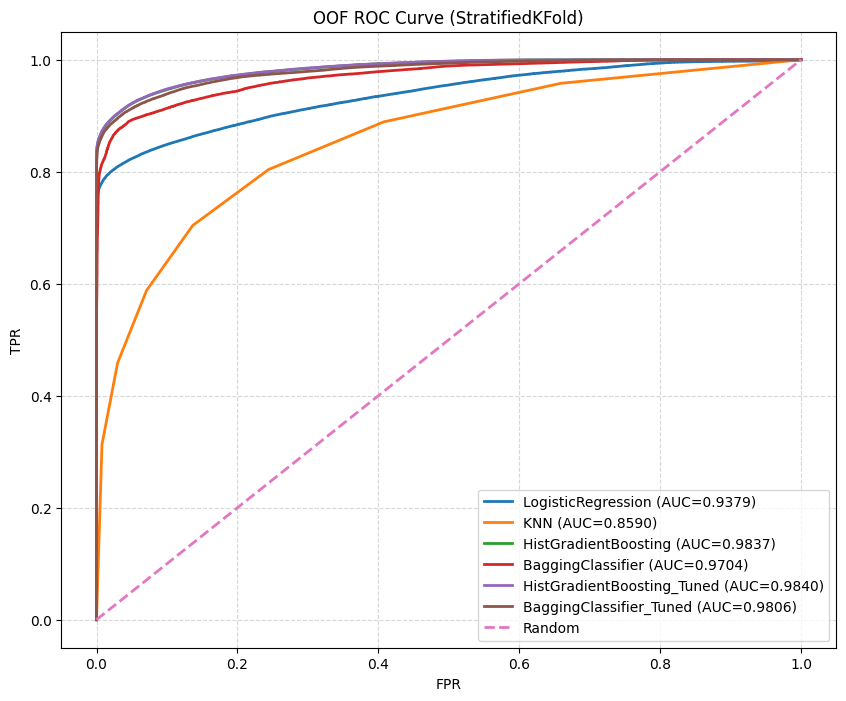

In [16]:
plt.figure(figsize=(10, 8))
y_true_oof = np.array(tt_oof_true)

for model_name in base_models.keys():
    probs = tt_oof_probs.get(model_name, [])
    if len(probs) == len(y_true_oof) and len(probs) > 0:
        fpr, tpr, _ = roc_curve(y_true_oof, np.array(probs))
        auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC={auc_val:.4f})")

plt.plot([0, 1], [0, 1], linestyle="--", lw=2, label="Random")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("OOF ROC Curve (StratifiedKFold)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_summary = []

for model_name, model in base_models.items():
    accs, precs, recs, f1s, aucs, ibs_list = [], [], [], [], [], []

    for train_idx, val_idx in skf.split(X_numeric, y):
        X_tr_raw, X_val_raw = X_numeric.iloc[train_idx], X_numeric.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        m = clone(model)
        is_pipe = isinstance(m, Pipeline)
        is_tree_like = ("HistGradientBoosting" in model_name) or ("BaggingClassifier" in model_name)

        if is_pipe or is_tree_like:
            Xtr_used, Xval_used = X_tr_raw, X_val_raw
        else:
            sc = StandardScaler()
            Xtr_used = sc.fit_transform(X_tr_raw)
            Xval_used = sc.transform(X_val_raw)

        m.fit(Xtr_used, y_tr)

        yhat = m.predict(Xval_used)
        yprob = m.predict_proba(Xval_used)[:, 1] if hasattr(m, "predict_proba") else None

        accs.append(accuracy_score(y_val, yhat))
        precs.append(precision_score(y_val, yhat, zero_division=0))
        recs.append(recall_score(y_val, yhat, zero_division=0))
        f1s.append(f1_score(y_val, yhat, zero_division=0))

        ibs_list.append(brier_score_loss(y_val, yprob) if yprob is not None else np.nan)
        if yprob is not None:
            aucs.append(roc_auc_score(y_val, yprob))

    cv_summary.append({
        "Model": model_name,
        "CV_Accuracy_Mean": np.mean(accs),
        "CV_Precision_Mean": np.mean(precs),
        "CV_Recall_Mean": np.mean(recs),
        "CV_F1_Mean": np.mean(f1s),
        "CV_ROC_AUC_Mean": np.mean(aucs) if len(aucs) > 0 else np.nan,
        "CV_IBS_Mean": np.nanmean(ibs_list)
    })

cv_df = pd.DataFrame(cv_summary).sort_values("CV_Accuracy_Mean", ascending=False)
cv_df


,Model,CV_Accuracy_Mean,CV_Precision_Mean,CV_Recall_Mean,CV_F1_Mean,CV_ROC_AUC_Mean,CV_IBS_Mean
4,HistGradientBoosting_Tuned,0.943447,0.976505,0.886735,0.929457,0.983971,0.041963
2,HistGradientBoosting,0.943197,0.976797,0.885850,0.929102,0.983727,0.042208
5,BaggingClassifier_Tuned,0.939887,0.975919,0.878611,0.924710,0.980617,0.046428
3,BaggingClassifier,0.928932,0.964598,0.862509,0.910700,0.970476,0.067412
0,LogisticRegression,0.885523,0.999646,0.727796,0.842326,0.937919,0.090582
1,KNN,0.796432,0.788737,0.704097,0.744011,0.859014,0.146249


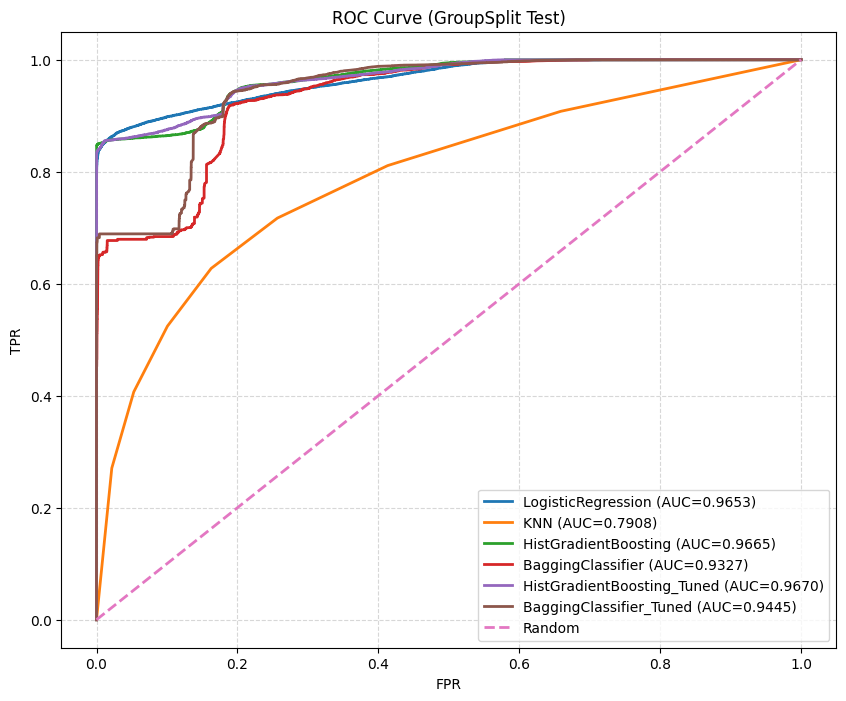

In [18]:
plt.figure(figsize=(10, 8))

for model_name, res in base_model_results.items():
    if res["y_pred_proba"] is not None:
        fpr, tpr, _ = roc_curve(y_test, res["y_pred_proba"])
        plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC={res['roc_auc']:.4f})")

plt.plot([0, 1], [0, 1], linestyle="--", lw=2, label="Random")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (GroupSplit Test)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


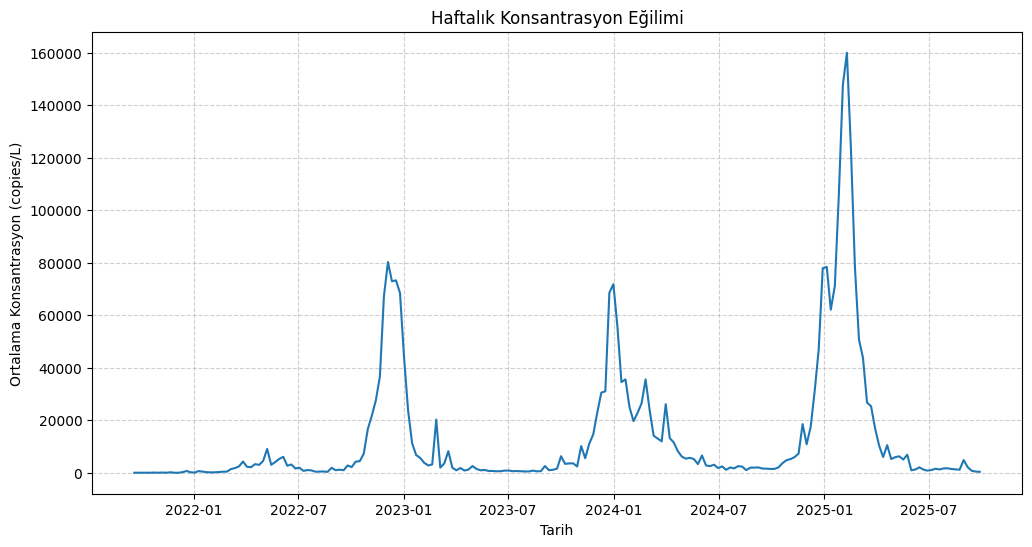

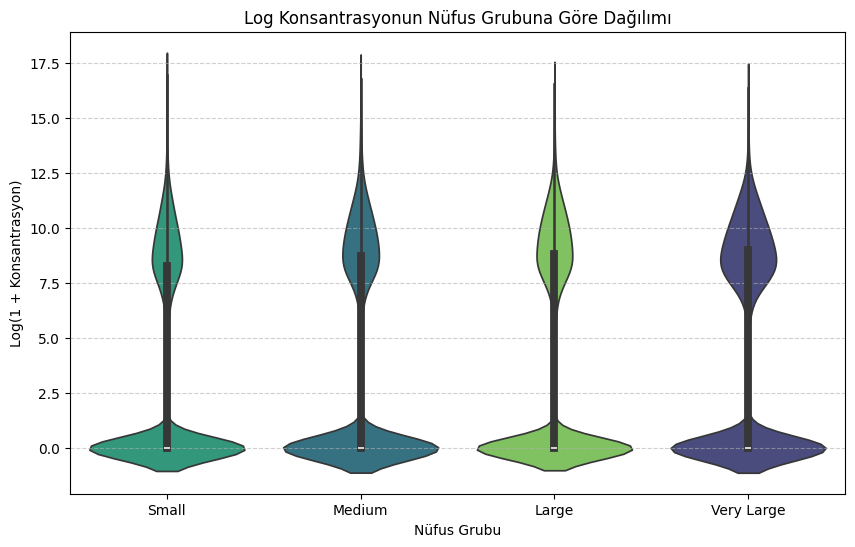

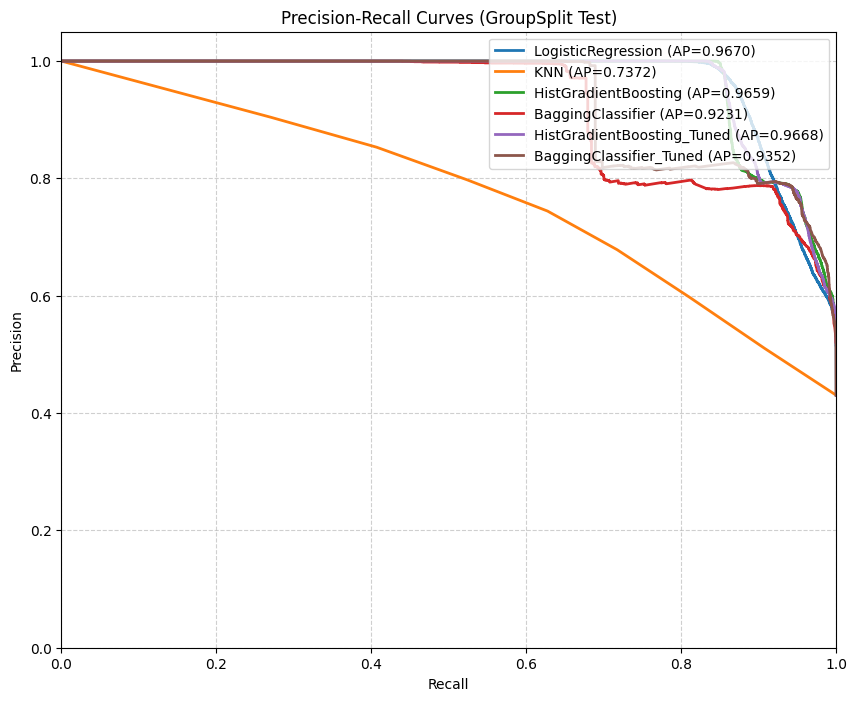

In [19]:
plt.figure(figsize=(12, 6))
weekly_avg = (
    df.dropna(subset=["sample_collect_date"])
      .set_index("sample_collect_date")["pcr_target_avg_conc"]
      .resample("W").mean()
      .reset_index()
)
sns.lineplot(data=weekly_avg, x="sample_collect_date", y="pcr_target_avg_conc")
plt.title("Haftalık Konsantrasyon Eğilimi")
plt.xlabel("Tarih")
plt.ylabel("Ortalama Konsantrasyon (copies/L)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(
    x=df["population_group"].astype(str),
    y="log_pcr_target_conc",
    data=df,
    order=["Small", "Medium", "Large", "Very Large"],
    palette="viridis",
    hue=df["population_group"].astype(str),
    legend=False
)
plt.title("Log Konsantrasyonun Nüfus Grubuna Göre Dağılımı")
plt.xlabel("Nüfus Grubu")
plt.ylabel("Log(1 + Konsantrasyon)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

plt.figure(figsize=(10, 8))
for model_name, results in base_model_results.items():
    if results["avg_precision"] is not None:
        precision, recall, _ = precision_recall_curve(y_test, results["y_pred_proba"])
        plt.plot(recall, precision, lw=2, label=f"{model_name} (AP={results['avg_precision']:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (GroupSplit Test)")
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()


## Feature Selection ve Dimension Reduction

Model performansını ve yorumlanabilirliği artırmak amacıyla:

### Feature Selection
- SelectKBest
- Recursive Feature Elimination (RFE)
- SelectFromModel

### Dimension Reduction
- PCA
- LDA

yöntemleri uygulanmış ve sonuçlar karşılaştırılmıştır.


In [20]:
feature_selection_techniques = {
    "SelectKBest (k=8)": SelectKBest(score_func=f_classif, k=min(8, len(features_fs))),
    "RFE (n=8)": RFE(
        estimator=LogisticRegression(random_state=42, max_iter=3000),
        n_features_to_select=min(8, len(features_fs))
    ),
    "SelectFromModel": SelectFromModel(
        LogisticRegression(random_state=42, penalty="l1", solver="saga", max_iter=5000),
        max_features=min(8, len(features_fs))
    )
}


In [21]:
all_results = []
all_visualization_data = []

for model_name, results in base_model_results.items():
    ibs = results.get("ibs", np.nan)
    all_results.append({
        "Model": model_name,
        "Technique": "Baseline (All Features)",
        "Num_Features": len(features_fs),
        "Accuracy": results["accuracy"],
        "ROC_AUC": results["roc_auc"] if results["roc_auc"] else 0,
        "Avg_Precision": results["avg_precision"] if results["avg_precision"] else 0,
        "IBS": ibs,
        "Type": "Baseline"
    })

    all_visualization_data.append({
        "Model": model_name,
        "Technique": "Baseline (All Features)",
        "Type": "Baseline",
        "Confusion_Matrix": results["confusion_matrix"],
        "Y_Pred_Proba": results["y_pred_proba"],
        "ROC_AUC": results["roc_auc"],
        "Avg_Precision": results["avg_precision"],
        "IBS": ibs
    })


In [22]:
for fs_name, fs_technique in feature_selection_techniques.items():
    try:
        X_selected = fs_technique.fit_transform(X_train_scaled_fs, y_train)

        selected_features_mask = fs_technique.get_support() if hasattr(fs_technique, "get_support") else fs_technique.support_
        selected_features = [features_fs[i] for i in range(len(features_fs)) if selected_features_mask[i]]

        X_test_selected = fs_technique.transform(X_test_scaled_fs)

        for model_name, original_model in base_models.items():
            if isinstance(original_model, Pipeline):
                continue

            model = clone(original_model)
            model.fit(X_selected, y_train)

            y_pred = model.predict(X_test_selected)
            y_pred_proba = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, "predict_proba") else None

            accuracy = accuracy_score(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test, y_pred)

            roc_auc_val = auc(*roc_curve(y_test, y_pred_proba)[:2]) if y_pred_proba is not None else np.nan
            avg_precision = average_precision_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan
            ibs = brier_score_loss(y_test, y_pred_proba) if y_pred_proba is not None else np.nan

            all_results.append({
                "Model": model_name,
                "Technique": fs_name,
                "Num_Features": len(selected_features),
                "Accuracy": accuracy,
                "ROC_AUC": roc_auc_val if not np.isnan(roc_auc_val) else 0,
                "Avg_Precision": avg_precision if not np.isnan(avg_precision) else 0,
                "IBS": ibs,
                "Type": "Feature Selection"
            })

            all_visualization_data.append({
                "Model": model_name,
                "Technique": fs_name,
                "Type": "Feature Selection",
                "Confusion_Matrix": conf_matrix,
                "Y_Pred_Proba": y_pred_proba,
                "ROC_AUC": roc_auc_val,
                "Avg_Precision": avg_precision,
                "IBS": ibs
            })

    except Exception as e:
        print(fs_name, "hata:", e)


In [23]:
dimension_reduction_techniques = {
    "PCA (n=8)": PCA(n_components=min(8, X_train_scaled_fs.shape[1]), random_state=42),
    "LDA": LDA(n_components=1)
}


In [24]:
for dr_name, dr_technique in dimension_reduction_techniques.items():
    try:
        X_reduced = dr_technique.fit_transform(X_train_scaled_fs, y_train)
        X_test_reduced = dr_technique.transform(X_test_scaled_fs)

        for model_name, original_model in base_models.items():
            if isinstance(original_model, Pipeline):
                continue

            model = clone(original_model)
            model.fit(X_reduced, y_train)

            y_pred = model.predict(X_test_reduced)
            y_pred_proba = model.predict_proba(X_test_reduced)[:, 1] if hasattr(model, "predict_proba") else None

            accuracy = accuracy_score(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test, y_pred)

            roc_auc_val = auc(*roc_curve(y_test, y_pred_proba)[:2]) if y_pred_proba is not None else np.nan
            avg_precision = average_precision_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan
            ibs = brier_score_loss(y_test, y_pred_proba) if y_pred_proba is not None else np.nan

            all_results.append({
                "Model": model_name,
                "Technique": dr_name,
                "Num_Features": X_reduced.shape[1],
                "Accuracy": accuracy,
                "ROC_AUC": roc_auc_val if not np.isnan(roc_auc_val) else 0,
                "Avg_Precision": avg_precision if not np.isnan(avg_precision) else 0,
                "IBS": ibs,
                "Type": "Dimension Reduction"
            })

            all_visualization_data.append({
                "Model": model_name,
                "Technique": dr_name,
                "Type": "Dimension Reduction",
                "Confusion_Matrix": conf_matrix,
                "Y_Pred_Proba": y_pred_proba,
                "ROC_AUC": roc_auc_val,
                "Avg_Precision": avg_precision,
                "IBS": ibs
            })

    except Exception as e:
        print(dr_name, "hata:", e)


## Performans Metrikleri

Modeller aşağıdaki metrikler ile değerlendirilmiştir:

- Accuracy
- Precision
- Recall
- F1-score
- ROC AUC
- Average Precision
- Brier Score (IBS)

Bu metrikler hem test seti hem de çapraz doğrulama sonuçları için raporlanmıştır.


In [25]:
results_df = pd.DataFrame(all_results)
results_df.head()


,Model,Technique,Num_Features,Accuracy,ROC_AUC,Avg_Precision,IBS,Type
0,LogisticRegression,Baseline (All Features),18,0.897605,0.965323,0.966978,0.078830,Baseline
1,KNN,Baseline (All Features),18,0.746923,0.790757,0.737246,0.187786,Baseline
2,HistGradientBoosting,Baseline (All Features),18,0.864619,0.966469,0.965907,0.125071,Baseline
3,BaggingClassifier,Baseline (All Features),18,0.853421,0.932705,0.923127,0.109590,Baseline
4,HistGradientBoosting_Tuned,Baseline (All Features),18,0.863621,0.966960,0.966786,0.126685,Baseline


In [26]:
print(f"{'Model':<25} {'Teknik':<25} {'Tip':<20} {'#Feat':<6} {'Acc':<10} {'AUC':<10} {'AP':<10} {'IBS':<10}")
print("-" * 120)

for _, row in results_df.iterrows():
    print(f"{row['Model']:<25} {row['Technique']:<25} {row['Type']:<20} {int(row['Num_Features']):<6} "
          f"{row['Accuracy']:<10.4f} {row['ROC_AUC']:<10.4f} {row['Avg_Precision']:<10.4f} {row['IBS']:<10.4f}")


Model                     Teknik                    Tip                  #Feat  Acc        AUC        AP         IBS       
------------------------------------------------------------------------------------------------------------------------
LogisticRegression        Baseline (All Features)   Baseline             18     0.8976     0.9653     0.9670     0.0788    
KNN                       Baseline (All Features)   Baseline             18     0.7469     0.7908     0.7372     0.1878    
HistGradientBoosting      Baseline (All Features)   Baseline             18     0.8646     0.9665     0.9659     0.1251    
BaggingClassifier         Baseline (All Features)   Baseline             18     0.8534     0.9327     0.9231     0.1096    
HistGradientBoosting_Tuned Baseline (All Features)   Baseline             18     0.8636     0.9670     0.9668     0.1267    
BaggingClassifier_Tuned   Baseline (All Features)   Baseline             18     0.8638     0.9445     0.9352     0.1146    
LogisticRe

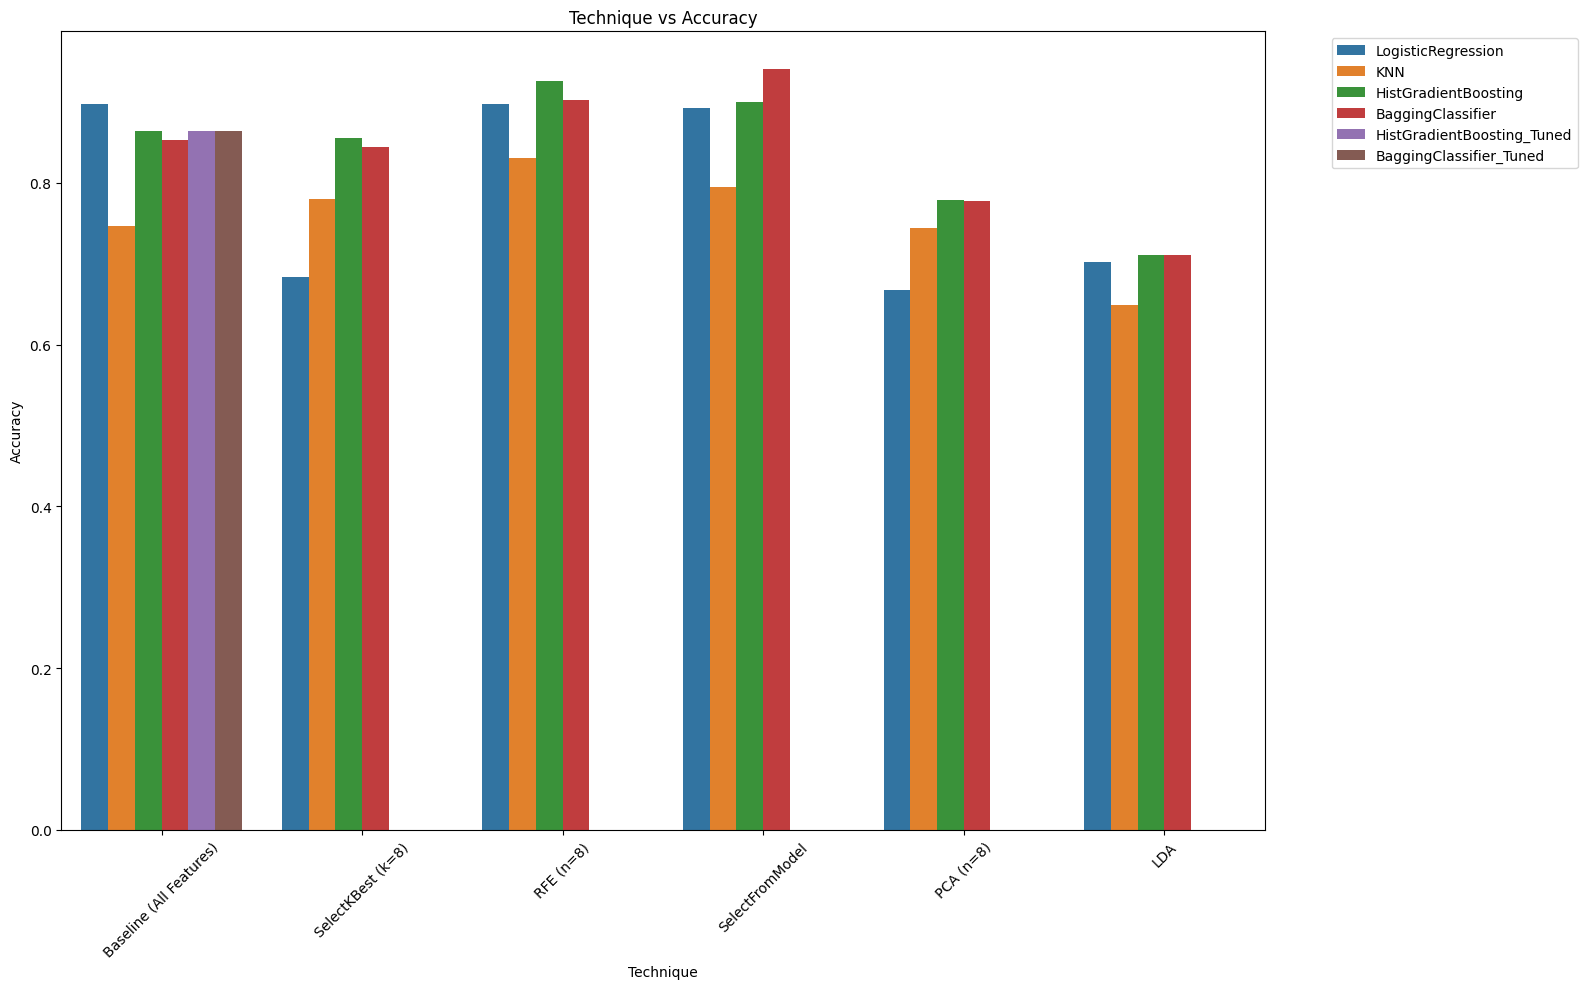

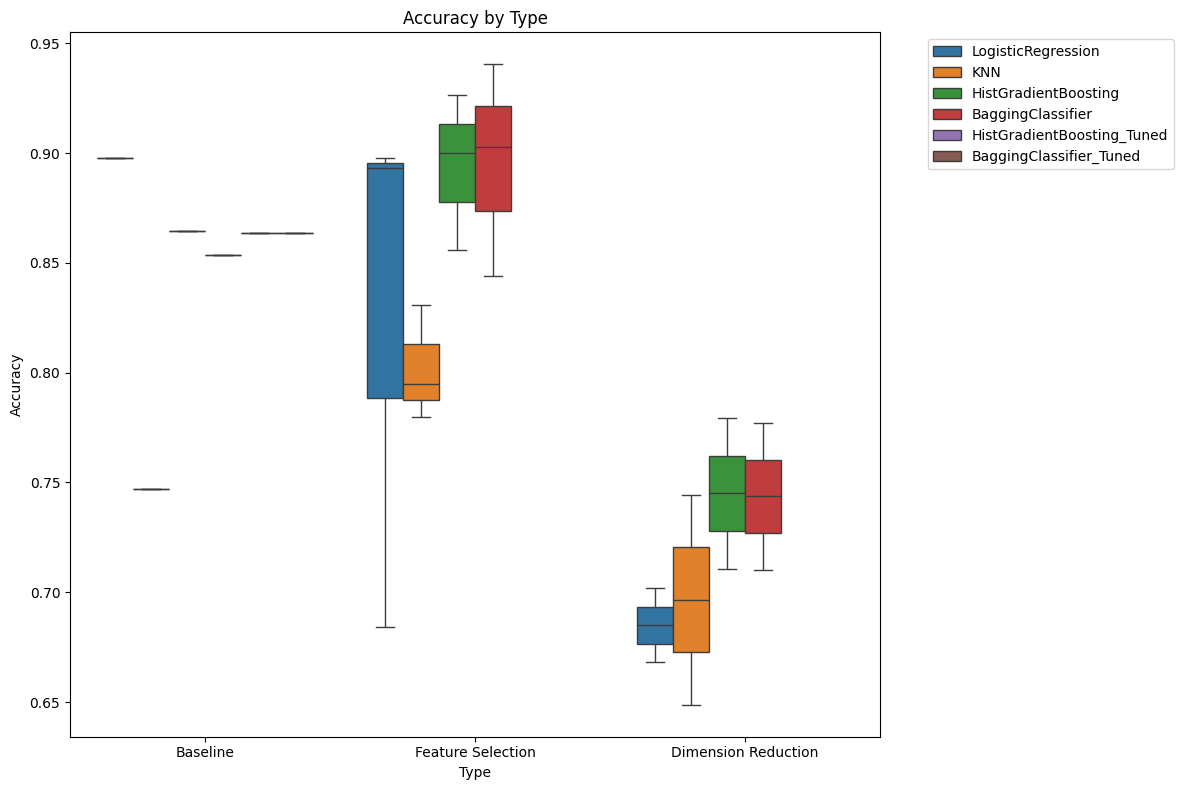

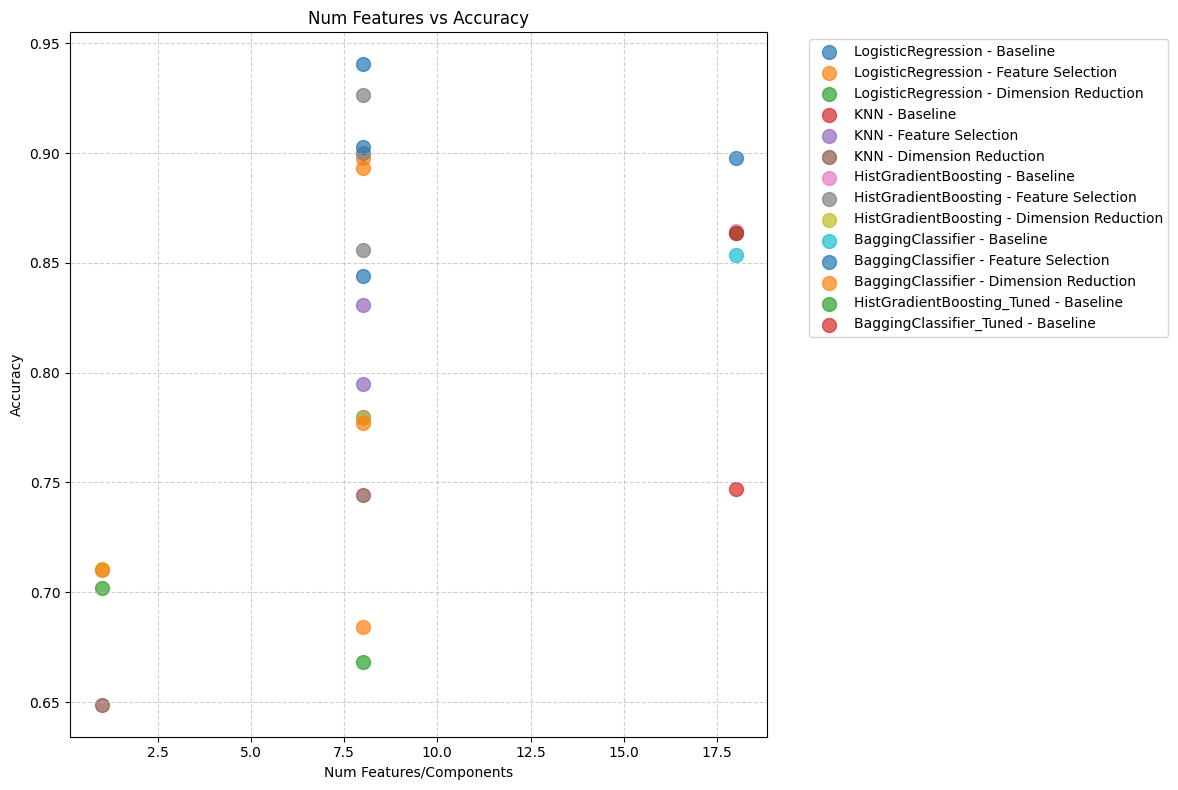

In [27]:
plt.figure(figsize=(16, 10))
sns.barplot(data=results_df, x="Technique", y="Accuracy", hue="Model")
plt.title("Technique vs Accuracy")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=results_df, x="Type", y="Accuracy", hue="Model")
plt.title("Accuracy by Type")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
for model in results_df["Model"].unique():
    for technique_type in results_df["Type"].unique():
        model_data = results_df[(results_df["Model"] == model) & (results_df["Type"] == technique_type)]
        if not model_data.empty:
            plt.scatter(model_data["Num_Features"], model_data["Accuracy"], s=100, alpha=0.7, label=f"{model} - {technique_type}")

plt.xlabel("Num Features/Components")
plt.ylabel("Accuracy")
plt.title("Num Features vs Accuracy")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


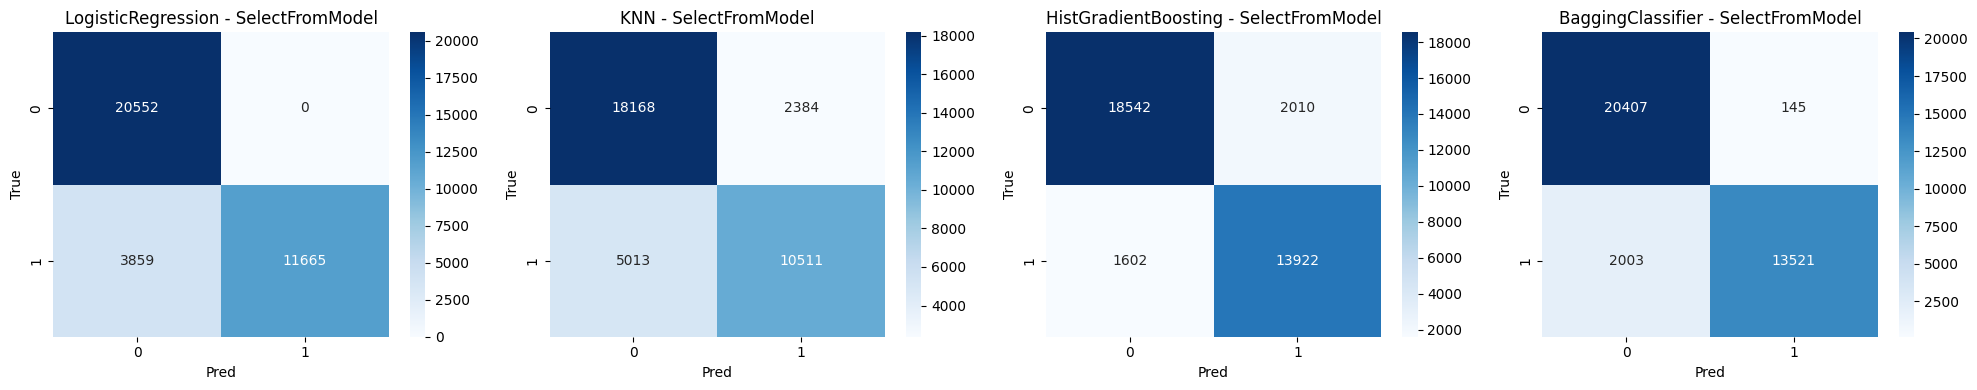

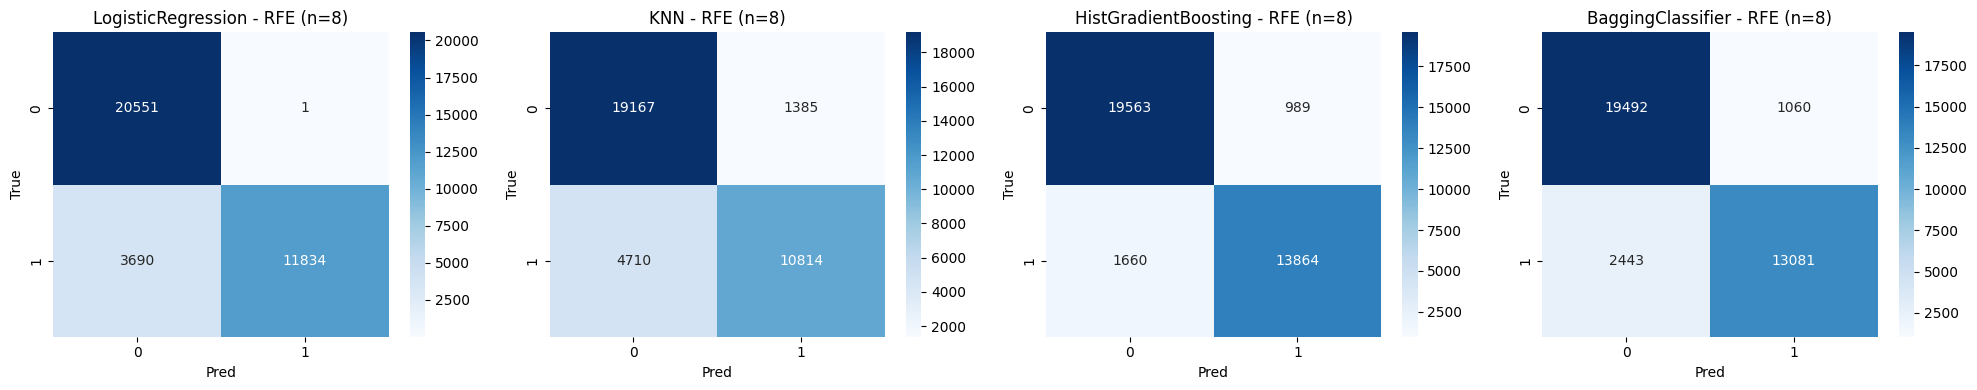

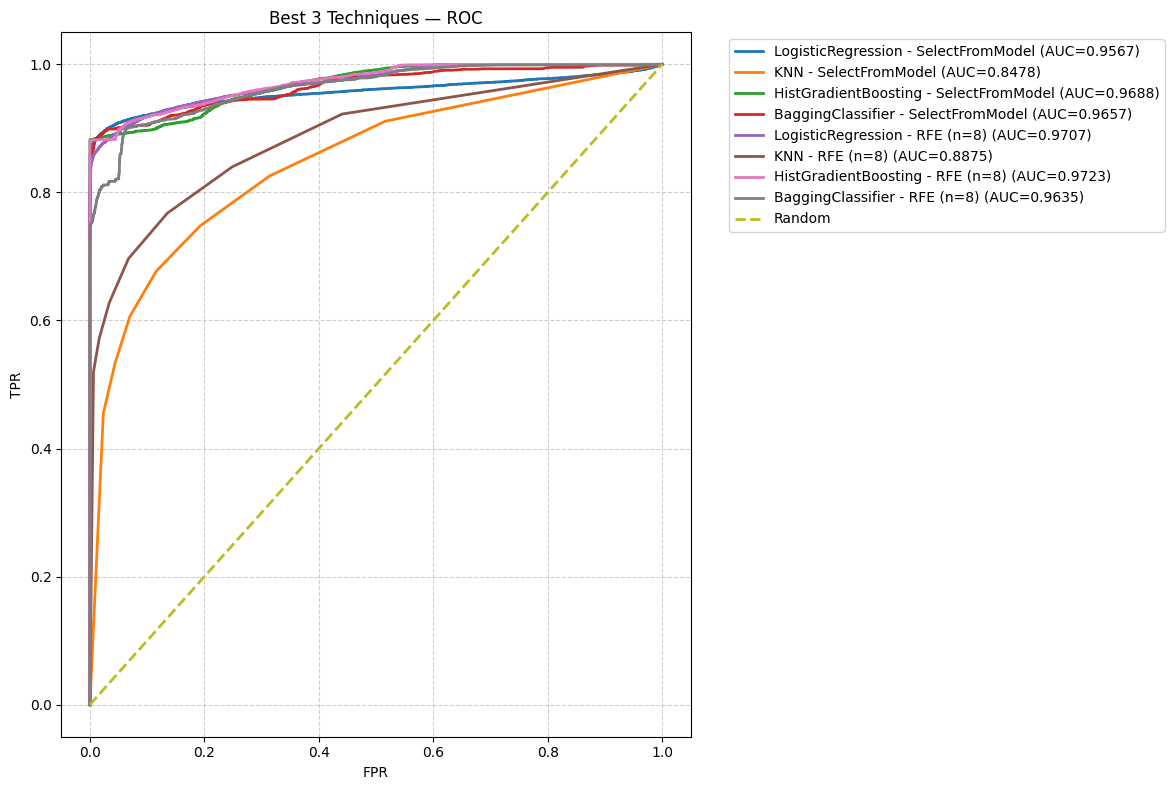

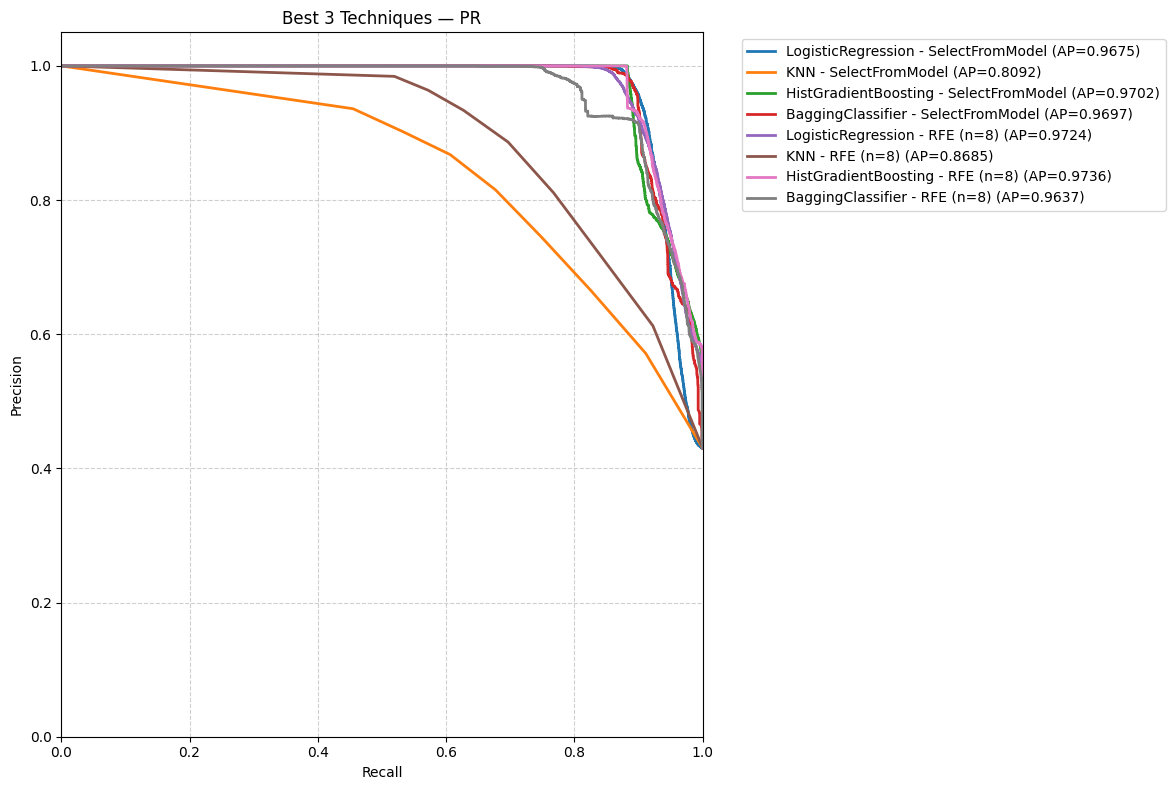

In [28]:
best_3_techniques = results_df.nlargest(3, "Accuracy")["Technique"].unique()

for technique in best_3_techniques:
    technique_data = [d for d in all_visualization_data if d["Technique"] == technique]
    if not technique_data:
        continue

    fig, axes = plt.subplots(1, len(technique_data), figsize=(5 * len(technique_data), 4))
    if len(technique_data) == 1:
        axes = [axes]

    for idx, d in enumerate(technique_data):
        sns.heatmap(d["Confusion_Matrix"], annot=True, fmt="d", cmap="Blues", ax=axes[idx],
                    xticklabels=["0", "1"], yticklabels=["0", "1"])
        axes[idx].set_title(f"{d['Model']} - {technique}")
        axes[idx].set_xlabel("Pred")
        axes[idx].set_ylabel("True")

    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 8))
for technique in best_3_techniques:
    technique_data = [d for d in all_visualization_data if d["Technique"] == technique and d["Y_Pred_Proba"] is not None]
    for d in technique_data:
        fpr, tpr, _ = roc_curve(y_test, d["Y_Pred_Proba"])
        plt.plot(fpr, tpr, lw=2, label=f"{d['Model']} - {technique} (AUC={d['ROC_AUC']:.4f})")

plt.plot([0, 1], [0, 1], lw=2, linestyle="--", label="Random")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Best 3 Techniques — ROC")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
for technique in best_3_techniques:
    technique_data = [d for d in all_visualization_data if d["Technique"] == technique and d["Y_Pred_Proba"] is not None]
    for d in technique_data:
        precision, recall, _ = precision_recall_curve(y_test, d["Y_Pred_Proba"])
        plt.plot(recall, precision, lw=2, label=f"{d['Model']} - {technique} (AP={d['Avg_Precision']:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Best 3 Techniques — PR")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()


In [29]:
best_accuracy = results_df.nlargest(10, "Accuracy")
best_accuracy[["Model", "Technique", "Type", "Num_Features", "Accuracy", "IBS"]]


,Model,Technique,Type,Num_Features,Accuracy,IBS
17,BaggingClassifier,SelectFromModel,Feature Selection,8,0.940459,0.081347
12,HistGradientBoosting,RFE (n=8),Feature Selection,8,0.926572,0.060305
13,BaggingClassifier,RFE (n=8),Feature Selection,8,0.902899,0.076102
16,HistGradientBoosting,SelectFromModel,Feature Selection,8,0.899878,0.062657
10,LogisticRegression,RFE (n=8),Feature Selection,8,0.897688,0.077206
0,LogisticRegression,Baseline (All Features),Baseline,18,0.897605,0.078830
14,LogisticRegression,SelectFromModel,Feature Selection,8,0.893031,0.080253
2,HistGradientBoosting,Baseline (All Features),Baseline,18,0.864619,0.125071
5,BaggingClassifier_Tuned,Baseline (All Features),Baseline,18,0.863815,0.114560
4,HistGradientBoosting_Tuned,Baseline (All Features),Baseline,18,0.863621,0.126685


In [30]:
for model_name, results in base_model_results.items():
    print("MODEL:", model_name)

    y_true = y_test
    y_pred = results["y_pred"]

    print(classification_report(y_true, y_pred, target_names=["0", "1"], digits=4))

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print("TN:", tn, "FP:", fp, "FN:", fn, "TP:", tp)
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("IBS:", round(results.get("ibs", np.nan), 4))
    print("-" * 50)

class_metrics_rows = []

for model_name, results in base_model_results.items():
    rep = classification_report(
        y_test, results["y_pred"],
        target_names=["0", "1"],
        output_dict=True,
        zero_division=0
    )
    for cls in ["0", "1"]:
        class_metrics_rows.append({
            "Model": model_name,
            "Class": cls,
            "Precision": rep[cls]["precision"],
            "Recall": rep[cls]["recall"],
            "F1": rep[cls]["f1-score"],
            "Support": rep[cls]["support"],
            "IBS": results.get("ibs", np.nan)
        })

df_class_metrics = pd.DataFrame(class_metrics_rows)
df_class_metrics.head(20)


MODEL: LogisticRegression
              precision    recall  f1-score   support

           0     0.8476    1.0000    0.9175     20552
           1     1.0000    0.7620    0.8650     15524

    accuracy                         0.8976     36076
   macro avg     0.9238    0.8810    0.8912     36076
weighted avg     0.9132    0.8976    0.8949     36076

TN: 20552 FP: 0 FN: 3694 TP: 11830
Accuracy: 0.8976
IBS: 0.0788
--------------------------------------------------
MODEL: KNN
              precision    recall  f1-score   support

           0     0.7484    0.8372    0.7903     20552
           1     0.7443    0.6274    0.6809     15524

    accuracy                         0.7469     36076
   macro avg     0.7464    0.7323    0.7356     36076
weighted avg     0.7466    0.7469    0.7432     36076

TN: 17206 FP: 3346 FN: 5784 TP: 9740
Accuracy: 0.7469
IBS: 0.1878
--------------------------------------------------
MODEL: HistGradientBoosting
              precision    recall  f1-score   sup

,Model,Class,Precision,Recall,F1,Support,IBS
0,LogisticRegression,0,0.847645,1.000000,0.917541,20552.0,0.078830
1,LogisticRegression,1,1.000000,0.762046,0.864956,15524.0,0.078830
2,KNN,0,0.748412,0.837193,0.790317,20552.0,0.187786
3,KNN,1,0.744307,0.627416,0.680881,15524.0,0.187786
4,HistGradientBoosting,0,0.948375,0.806248,0.871555,20552.0,0.125071
5,HistGradientBoosting,1,0.785960,0.941896,0.856892,15524.0,0.125071
6,BaggingClassifier,0,0.917505,0.816076,0.863824,20552.0,0.109590
7,BaggingClassifier,1,0.787593,0.902860,0.841297,15524.0,0.109590
8,HistGradientBoosting_Tuned,0,0.942482,0.810043,0.871258,20552.0,0.126685
9,HistGradientBoosting_Tuned,1,0.787964,0.934553,0.855021,15524.0,0.126685


In [31]:
model_comparison = results_df.groupby("Model").agg({
    "Accuracy": ["mean", "max", "min"],
    "ROC_AUC": "mean",
    "IBS": "mean"
}).round(4)

model_comparison


Accuracy                 ROC_AUC     IBS
                               mean     max     min    mean    mean
Model                                                              
BaggingClassifier            0.8381  0.9405  0.7103  0.9004  0.1230
BaggingClassifier_Tuned      0.8638  0.8638  0.8638  0.9445  0.1146
HistGradientBoosting         0.8395  0.9266  0.7107  0.9082  0.1183
HistGradientBoosting_Tuned   0.8636  0.8636  0.8636  0.9670  0.1267
KNN                          0.7576  0.8311  0.6488  0.8009  0.1766
LogisticRegression           0.7904  0.8977  0.6681  0.8381  0.1459

## Değerlendirme

Bu çalışmada, Influenza A’nın atık su verilerinden tahmini için
farklı makine öğrenmesi yaklaşımları karşılaştırılmıştır.

Sonuçlar:
- Ensemble modellerin genel olarak daha yüksek performans sunduğunu
- Feature selection ve dimension reduction tekniklerinin bazı modellerde
  performansı artırabildiğini
- Group-aware veri ayrımının daha gerçekçi sonuçlar ürettiğini

göstermektedir.
